In [1]:
%load_ext memory_profiler

In [2]:
%%timeit -r 50 -n 1
%%memit
import cv2
import mediapipe as mp
import numpy as np

# mediapipe 기능 불러오기
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 영상 파일 열기
cap = cv2.VideoCapture("../videos/attention.mp4")

# 총 프레임 개수 체크
total_frame_no = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Keypoints를 저장하기 위한 딕셔너리 초기화
keypoints_dict = {}

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    frame_num = 0
    last_valid_keypoints = None
    while cap.isOpened():
        ret, frame = cap.read()

        # 프레임이 제대로 읽혔는지 확인
        if not ret:
            break

        # 프레임의 너비와 높이 가져오기
        height, width, _ = frame.shape

        # BGR을 RGB로 변환
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 성능 향상을 위해, 참조로 전달하기 위해 이미지를 변경할 수 없음을 표시합니다.
        image.flags.writeable = False

        # MediaPipe Pose 처리
        results = pose.process(image)

        # Keypoints 가져오기
        if results.pose_landmarks:
            keypoints = results.pose_landmarks.landmark
            keypoints_dict[frame_num] = [(int(keypoints[11].x * width), int(keypoints[11].y * height)),
                                         (int(keypoints[12].x * width), int(keypoints[12].y * height))]
            last_valid_keypoints = keypoints_dict[frame_num]
        else:
            keypoints_dict[frame_num] = last_valid_keypoints  # Keypoints가 감지되지 않으면 마지막 유효한 keypoints 사용

        frame_num += 1

# 누락된 Keypoints에 대한 후처리
# 처음 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no):
    if keypoints_dict[i] is not None:
        for j in range(i):
            keypoints_dict[j] = keypoints_dict[i]
        break

# 중간에서 Keypoints가 없는 경우
start_frame = None
for i in range(total_frame_no):
    if keypoints_dict[i] is None:
        if start_frame is None:
            start_frame = i - 1
    else:
        if start_frame is not None:
            # 누락된 Keypoints에 대한 선형 보간
            start = np.array(keypoints_dict[start_frame])
            end = np.array(keypoints_dict[i])
            for j in range(start_frame + 1, i):
                keypoints_dict[j] = tuple(int(start + (end - start) * (j - start_frame) / (i - start_frame)))
            start_frame = None

# 마지막 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no - 1, -1, -1):
    if keypoints_dict[i] is not None:
        for j in range(i + 1, total_frame_no):
            keypoints_dict[j] = keypoints_dict[i]
        break

cap.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


peak memory: 916.67 MiB, increment: 852.64 MiB
peak memory: 936.39 MiB, increment: 93.84 MiB
peak memory: 945.72 MiB, increment: 54.03 MiB
peak memory: 948.53 MiB, increment: 3.31 MiB
peak memory: 981.17 MiB, increment: 33.14 MiB
peak memory: 980.67 MiB, increment: 0.00 MiB
peak memory: 1003.73 MiB, increment: 23.61 MiB
peak memory: 1003.23 MiB, increment: 0.00 MiB
peak memory: 1021.30 MiB, increment: 20.84 MiB
peak memory: 1020.80 MiB, increment: 0.00 MiB
peak memory: 931.12 MiB, increment: 19.95 MiB
peak memory: 956.38 MiB, increment: 40.75 MiB
peak memory: 963.12 MiB, increment: 7.31 MiB
peak memory: 995.06 MiB, increment: 45.23 MiB
peak memory: 1005.89 MiB, increment: 11.33 MiB
peak memory: 1005.39 MiB, increment: 0.00 MiB
peak memory: 944.59 MiB, increment: 40.83 MiB
peak memory: 935.95 MiB, increment: 50.33 MiB
peak memory: 948.64 MiB, increment: 13.19 MiB
peak memory: 955.38 MiB, increment: 18.91 MiB
peak memory: 954.84 MiB, increment: 0.00 MiB
peak memory: 960.14 MiB, increment

In [ ]:
%%timeit -r 50 -n 1
%%memit

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np

# TF Hub에서 모델 MoveNet-singlepose-thunder 로드
model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = model.signatures['serving_default']

# Threshold 설정
threshold = 0.5

# 비디오 소스 로드
video_source = '../videos/attention.mp4'  # 비디오 파일 경로 지정
cam = cv2.VideoCapture(video_source)

# 비디오 캡쳐 중 오류 확인
if not cam.isOpened():
    print('Error loading video')
    quit()

fps = cam.get(cv2.CAP_PROP_FPS)  # 영상의 원래 fps 사용

success, img = cam.read()

if not success:
    print('Error reading frame')
    quit()

y, x, _ = img.shape             # (x, y) = (1920, 1080)
keypoints_dict2 = {}             # {frame_number: [(left_shoulder_x, left_shoulder_y), (right_shoulder_x, right_shoulder_y)], ...}
frame_number = 0                # 프레임 번호를 저장할 변수 초기화

while success:
    # 비디오 or 이미지 한 프레임은 int32의 tensor로 출력됨
    # shape: 192x192x3 / channel 순서와 범위: RGB, [0, 255]
    tf_img = cv2.resize(img, (192, 192))
    tf_img = cv2.cvtColor(tf_img, cv2.COLOR_BGR2RGB)
    tf_img = np.asarray(tf_img)
    tf_img = np.expand_dims(tf_img, axis=0)

    # tf_img를 정수형 데이터로 변환 -> 비율 유지하여 size를 맞추기 위해 resize & padding
    image = tf.cast(tf_img, dtype=tf.int32)

    outputs = movenet(image)                # 모델 추론
    keypoints = outputs['output_0']         # Output is a [1, 1, 17, 3] tensor

    keypoints_coordinates = []

    for k in keypoints[0, 0, :, :]:
        k = k.numpy()                       # Numpy array로 변환

        if k[2] > threshold:                # 관절이 감지되었는지 확인
            # 마지막 차원의 첫 번째 두 채널은 17개 관절의 y, x 좌표
            # (이미지 프레임에 대해 정규화된 값, 즉 [0.0, 1.0] 범위)를 나타냄
            yc = int(k[0] * y)
            xc = int(k[1] * x)
            keypoints_coordinates.append((xc, yc))
        else:
            keypoints_coordinates.append(None)

    # left_shoulder = 5, right_shoulder = 6 인덱스
    keypoints_dict2[frame_number] = (keypoints_coordinates[5], keypoints_coordinates[6])

    success, img = cam.read()
    frame_number += 1  # 프레임 번호 증가

# 누락된 Keypoints에 대한 보간
total_frame_no = frame_number

# 처음 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no):
    if keypoints_dict2[i][0] is not None and keypoints_dict2[i][1] is not None:
        for j in range(i):
            keypoints_dict2[j] = keypoints_dict2[i]
        break

# 중간에서 Keypoints가 없는 경우
start_frame = None
for i in range(total_frame_no):
    if keypoints_dict2[i][0] is None or keypoints_dict2[i][1] is None:
        if start_frame is None:
            start_frame = i - 1
    else:
        if start_frame is not None:
            # 누락된 Keypoints에 대한 선형 보간
            start = np.array(keypoints_dict2[start_frame])
            end = np.array(keypoints_dict2[i])
            for j in range(start_frame + 1, i):
                keypoints_dict2[j] = tuple((start + (end - start) * (j - start_frame) / (i - start_frame)).astype(int))
            start_frame = None

# 마지막 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no - 1, -1, -1):
    if keypoints_dict2[i][0] is not None and keypoints_dict2[i][1] is not None:
        for j in range(i + 1, total_frame_no):
            keypoints_dict2[j] = keypoints_dict2[i]
        break

cam.release()


In [ ]:
# # 블레이즈 포즈
# peak memory: 916.67 MiB, increment: 852.64 MiB
# peak memory: 936.39 MiB, increment: 93.84 MiB
# peak memory: 945.72 MiB, increment: 54.03 MiB
# peak memory: 948.53 MiB, increment: 3.31 MiB
# peak memory: 981.17 MiB, increment: 33.14 MiB
# peak memory: 980.67 MiB, increment: 0.00 MiB
# peak memory: 1003.73 MiB, increment: 23.61 MiB
# peak memory: 1003.23 MiB, increment: 0.00 MiB
# peak memory: 1021.30 MiB, increment: 20.84 MiB
# peak memory: 1020.80 MiB, increment: 0.00 MiB
# peak memory: 931.12 MiB, increment: 19.95 MiB
# peak memory: 956.38 MiB, increment: 40.75 MiB
# peak memory: 963.12 MiB, increment: 7.31 MiB
# peak memory: 995.06 MiB, increment: 45.23 MiB
# peak memory: 1005.89 MiB, increment: 11.33 MiB
# peak memory: 1005.39 MiB, increment: 0.00 MiB
# peak memory: 944.59 MiB, increment: 40.83 MiB
# peak memory: 935.95 MiB, increment: 50.33 MiB
# peak memory: 948.64 MiB, increment: 13.19 MiB
# peak memory: 955.38 MiB, increment: 18.91 MiB
# peak memory: 954.84 MiB, increment: 0.00 MiB
# peak memory: 960.14 MiB, increment: 18.25 MiB
# peak memory: 925.12 MiB, increment: 19.09 MiB
# peak memory: 936.02 MiB, increment: 11.39 MiB
# peak memory: 935.52 MiB, increment: 0.00 MiB
# peak memory: 930.69 MiB, increment: 1.83 MiB
# peak memory: 942.58 MiB, increment: 14.20 MiB
# peak memory: 957.66 MiB, increment: 35.70 MiB
# peak memory: 957.16 MiB, increment: 0.00 MiB
# peak memory: 933.58 MiB, increment: 18.80 MiB
# peak memory: 933.98 MiB, increment: 27.56 MiB
# peak memory: 939.34 MiB, increment: 33.58 MiB
# peak memory: 919.25 MiB, increment: 29.53 MiB
# peak memory: 921.19 MiB, increment: 64.89 MiB
# peak memory: 897.09 MiB, increment: 48.67 MiB
# peak memory: 922.81 MiB, increment: 26.22 MiB
# peak memory: 904.53 MiB, increment: 22.95 MiB
# peak memory: 900.34 MiB, increment: 47.50 MiB
# peak memory: 892.86 MiB, increment: 18.58 MiB
# peak memory: 908.33 MiB, increment: 18.98 MiB
# peak memory: 927.58 MiB, increment: 25.22 MiB
# peak memory: 979.88 MiB, increment: 89.69 MiB
# peak memory: 979.38 MiB, increment: 0.00 MiB
# peak memory: 960.31 MiB, increment: 28.12 MiB
# peak memory: 936.88 MiB, increment: 25.12 MiB
# peak memory: 931.16 MiB, increment: 0.94 MiB
# peak memory: 930.84 MiB, increment: 27.30 MiB
# peak memory: 930.64 MiB, increment: 24.28 MiB
# peak memory: 933.70 MiB, increment: 20.69 MiB
# peak memory: 945.50 MiB, increment: 13.88 MiB
# 1min 6s ± 946 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)


# # 무브넷
# peak memory: 1391.47 MiB, increment: 1326.17 MiB
# peak memory: 1949.12 MiB, increment: 690.84 MiB
# peak memory: 2093.75 MiB, increment: 131.72 MiB
# peak memory: 2249.56 MiB, increment: 259.19 MiB
# peak memory: 2332.66 MiB, increment: 213.73 MiB
# peak memory: 2372.97 MiB, increment: 172.94 MiB
# peak memory: 2445.12 MiB, increment: 174.86 MiB
# peak memory: 2074.11 MiB, increment: 56.97 MiB
# peak memory: 2254.42 MiB, increment: 146.83 MiB
# peak memory: 2305.69 MiB, increment: 148.44 MiB
# peak memory: 2359.61 MiB, increment: 91.83 MiB
# peak memory: 2008.41 MiB, increment: 19.05 MiB
# peak memory: 2277.70 MiB, increment: 105.20 MiB
# peak memory: 2339.81 MiB, increment: 89.55 MiB
# peak memory: 2291.77 MiB, increment: 44.17 MiB
# peak memory: 2227.92 MiB, increment: 134.16 MiB
# peak memory: 2282.91 MiB, increment: 61.53 MiB
# peak memory: 2278.03 MiB, increment: 42.83 MiB
# peak memory: 2294.98 MiB, increment: 30.53 MiB
# peak memory: 2236.86 MiB, increment: 101.00 MiB
# peak memory: 2268.08 MiB, increment: 24.48 MiB
# peak memory: 2151.44 MiB, increment: 183.34 MiB
# peak memory: 2162.70 MiB, increment: 136.78 MiB
# peak memory: 2125.47 MiB, increment: 135.20 MiB
# peak memory: 2103.69 MiB, increment: 171.34 MiB
# peak memory: 2205.83 MiB, increment: 125.55 MiB
# peak memory: 2152.98 MiB, increment: 176.23 MiB
# peak memory: 2133.08 MiB, increment: 280.86 MiB
# peak memory: 2223.28 MiB, increment: 139.41 MiB
# peak memory: 2170.16 MiB, increment: 0.00 MiB
# peak memory: 2080.02 MiB, increment: 218.03 MiB
# peak memory: 2228.45 MiB, increment: 53.70 MiB
# peak memory: 2224.52 MiB, increment: 156.30 MiB
# peak memory: 2282.64 MiB, increment: 95.75 MiB
# peak memory: 2212.77 MiB, increment: 36.86 MiB
# peak memory: 2176.61 MiB, increment: 36.09 MiB
# peak memory: 2145.44 MiB, increment: 15.95 MiB
# peak memory: 2197.19 MiB, increment: 151.64 MiB
# peak memory: 2219.53 MiB, increment: 50.47 MiB
# peak memory: 2262.16 MiB, increment: 65.38 MiB
# peak memory: 2252.89 MiB, increment: 109.64 MiB
# peak memory: 2310.98 MiB, increment: 51.53 MiB
# peak memory: 2350.94 MiB, increment: 53.38 MiB
# peak memory: 2266.19 MiB, increment: 54.30 MiB
# peak memory: 2282.84 MiB, increment: 103.55 MiB
# peak memory: 2322.95 MiB, increment: 54.16 MiB
# peak memory: 2293.75 MiB, increment: 86.45 MiB
# peak memory: 2347.89 MiB, increment: 62.39 MiB
# peak memory: 2355.16 MiB, increment: 92.89 MiB
# peak memory: 2311.72 MiB, increment: 127.92 MiB
# 1min 25s ± 8.68 s per loop (mean ± std. dev. of 50 runs, 1 loop each)


In [3]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns

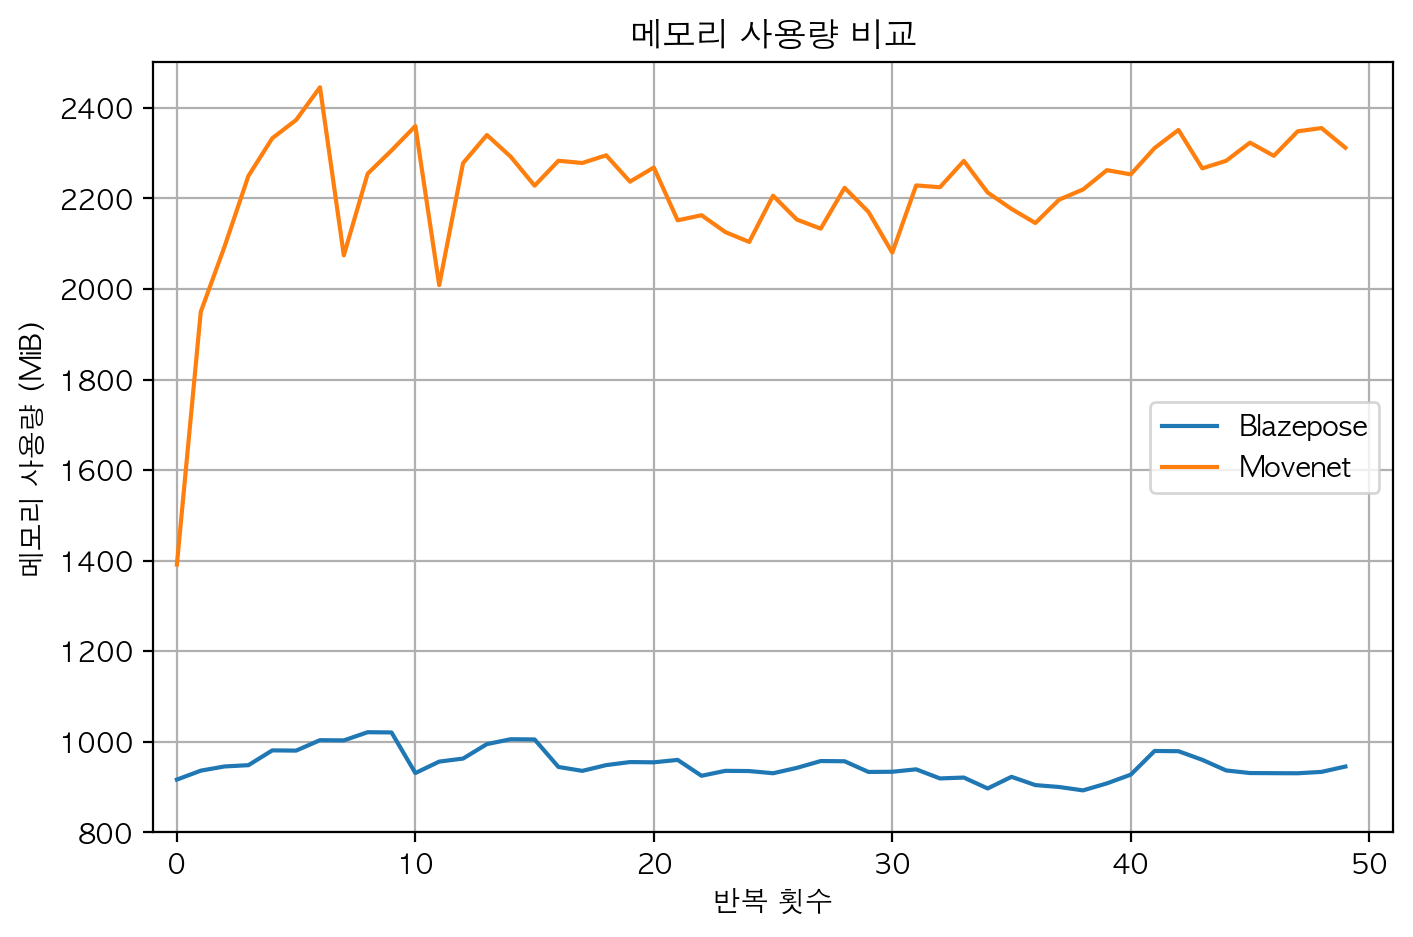

In [4]:
blazepose_memory = [916.67, 936.39, 945.72, 948.53, 981.17, 980.67, 1003.7, 1003.2, 1021.3, 1020.8,
                    931.12, 956.38, 963.12, 995.06, 1005.8, 1005.3, 944.59, 935.95, 948.64, 955.38,
                    954.84, 960.14, 925.12, 936.02, 935.52, 930.69, 942.58, 957.66, 957.16, 933.58,
                    933.98, 939.34, 919.25, 921.19, 897.09, 922.81, 904.53, 900.34, 892.86, 908.33,
                    927.58, 979.88, 979.38, 960.31, 936.88, 931.16, 930.84, 930.64, 933.70, 945.50]

movenet_memory = [1391.47, 1949.12, 2093.75, 2249.56, 2332.66, 2372.97, 2445.12, 2074.11, 2254.42, 2305.69,
                  2359.61, 2008.41, 2277.70, 2339.81, 2291.77, 2227.92, 2282.91, 2278.03, 2294.98, 2236.86,
                  2268.08, 2151.44, 2162.70, 2125.47, 2103.69, 2205.83, 2152.98, 2133.08, 2223.28, 2170.16,
                  2080.02, 2228.45, 2224.52, 2282.64, 2212.77, 2176.61, 2145.44, 2197.19, 2219.53, 2262.16,
                  2252.89, 2310.98, 2350.94, 2266.19, 2282.84, 2322.95, 2293.75, 2347.89, 2355.16, 2311.72]

plt.rcParams['font.family'] = 'AppleGothic'

plt.figure(figsize=(8,5))
plt.title("메모리 사용량 비교")
plt.plot(blazepose_memory, label="Blazepose")
plt.plot(movenet_memory, label="Movenet")

plt.xlim(-1, 51)
plt.ylim(800, 2500)
plt.xlabel("반복 횟수")
plt.ylabel("메모리 사용량 (MiB)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 1min 6s ± 946 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)
# 1min 25s ± 8.68 s per loop (mean ± std. dev. of 50 runs, 1 loop each)

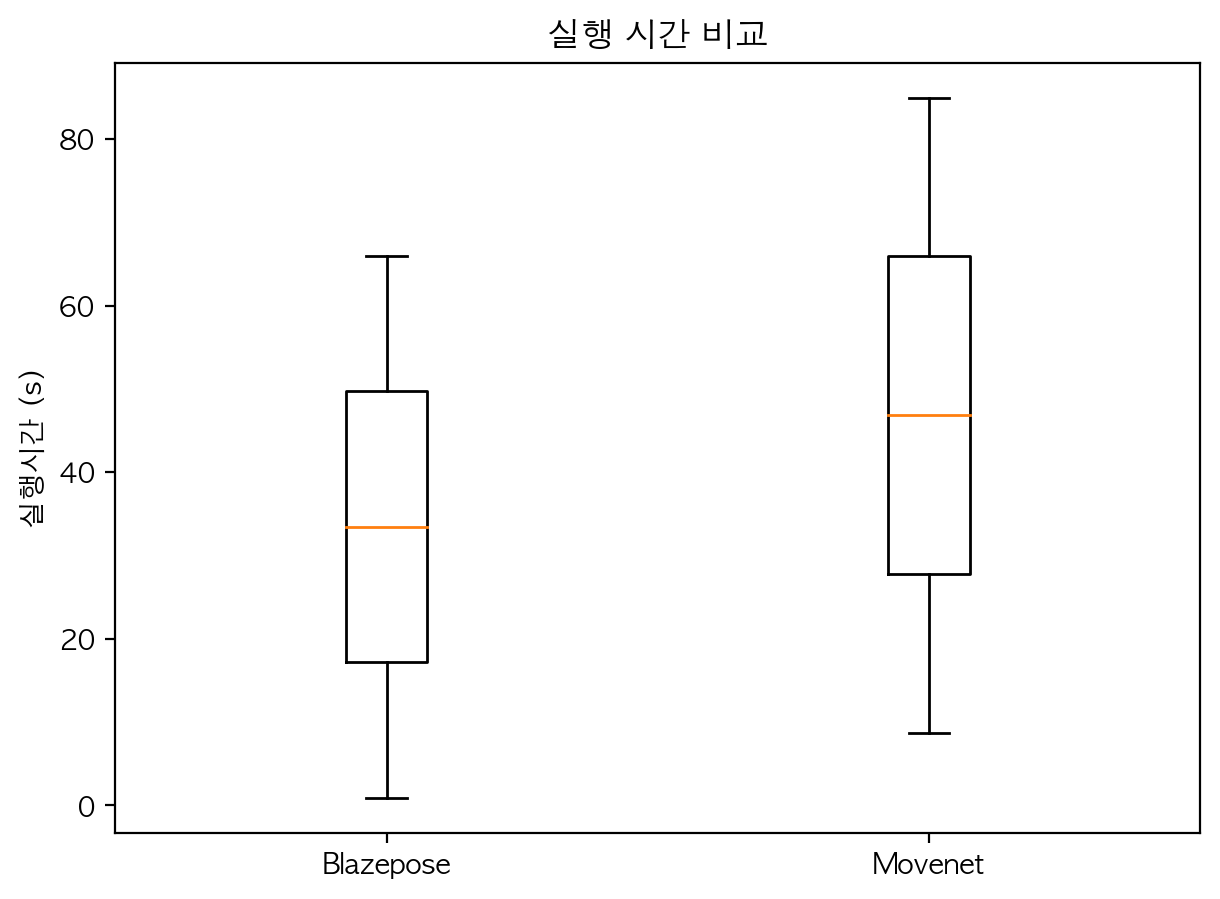

In [5]:
import matplotlib.pyplot as plt

# 실행 시간 데이터 (예시)
blazepose_times = [66, 0.946]  # Blazepose 실행 시간 데이터
movenet_times = [85, 8.68]  # Movenet 실행 시간 데이터

# boxplot
plt.figure(figsize=(7,5))
plt.boxplot([blazepose_times, movenet_times], labels=['Blazepose', 'Movenet'])

plt.ylabel('실행시간 (s)')
plt.title('실행 시간 비교')
plt.show()